# Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import scipy

# Preparation des données

## Importation

In [3]:
data_real = pd.read_csv('./data2.csv', sep=";")

## Affichage

In [5]:
#  Séléectionner les bonnes colonnes
data = data_real.iloc[:, [0, 1, 6]].to_numpy()
# print(data)
# Mettre en Serie temporelle
time_serie = pd.Series(data[:, 2], dtype='float64')

# Retirer les valeurs vides
time_serie = time_serie.dropna()

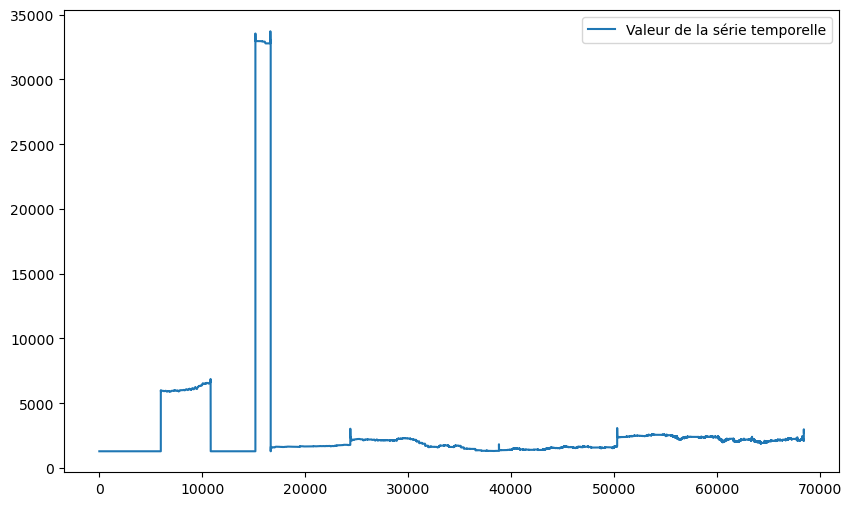

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(time_serie, label='Valeur de la série temporelle')
plt.legend()
plt.show()

On observe que les données sont corrompues.

Sur le début de la plage de données, on observe des paliers de valeurs, celles si ne varient pas ou peu et sont subitement projetées sur d'autres valeurs:

1) entre 0 et 10 000 on a un pic qui passe de 1 280 à environ 6 500
2) entre 15 000 et 20 000 on a un pic qui passe de 1 280 à 32 770

Un nettoyage des données se présente comme nécéssaire 

# Nettoyage des données

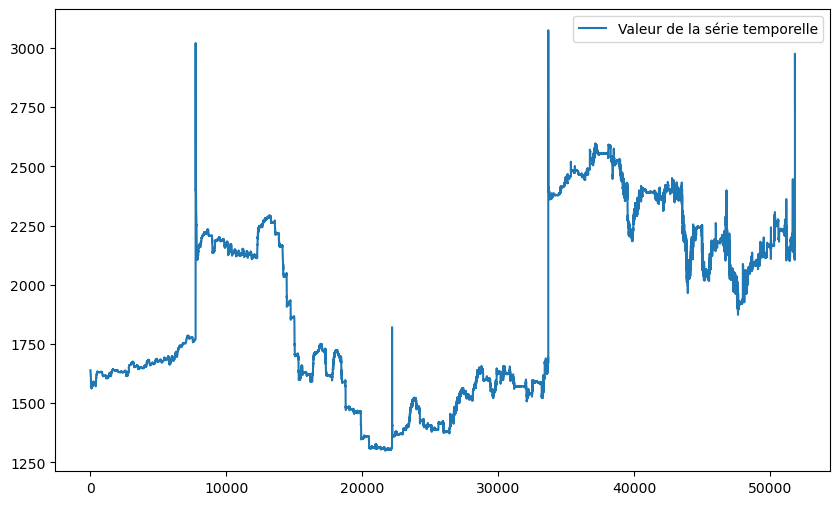

In [9]:
# D'après la base de donnée on obtient cet indice
data_crop = data[16656:, 2] 

# Transformation en série temporelle
time_serie_crop = pd.Series(data_crop, dtype='float64')

# Affichage de la série
plt.figure(figsize=(10, 6))
plt.plot(time_serie_crop, label='Valeur de la série temporelle')
plt.legend()
plt.show()

In [11]:
from datetime import datetime

# Exemple de données
data_time = data_real.iloc[16656:, 1].to_numpy()

# Conversion en objets datetime
datetime_data = [datetime.strptime(d, "%Y.%m.%d %H:%M") for d in data_time]

# Calcul des différences en minutes
differences_minutes = [
    (datetime_data[i] - datetime_data[i-1]).total_seconds() / 60
    for i in range(1, len(datetime_data))
]

# Affichage des résultats
print("Différences en minutes entre chaque données :")
print(np.unique(differences_minutes))


Différences en minutes entre chaque données :
[5.]


## Detection des discontinuités

In [13]:
def detect_pic(data, seuil=100):
    pic_indices = []
    offset_indices = []
    
    # Parcours des valeurs de la série
    for i in range(1, len(data) - 2):
        
        # on regarde si la différence entre les 2 valeurs est plus grande en valeur absolue que le seuil
        if np.abs(data[i] - data[i+1]) >= seuil :
            # si le saut suivant est aussi supérieur à un pic alors ceci est une valeur aberrante
            if np.abs(data[i+1] - data[i+2]) >= seuil : 
                pic_indices.append(i+1) 
            # sinon on considère qu'il y a un problème d'offset
            else : 
                offset_indices.append(i+1) 
        
    return pic_indices, offset_indices

In [15]:
pic, offset = detect_pic(data_crop)

print("Nombre de pics détectés :", len(pic))
print("Nombre d'offset détectés :", len(offset))
print("Indices des pics :", pic)
print("Indices des offset :", offset)
print("Valeurs des pics :", data_crop[pic])

Nombre de pics détectés : 15
Nombre d'offset détectés : 11
Indices des pics : [7733, 7734, 7735, 22178, 33666, 33667, 33668, 51166, 51167, 51168, 51644, 51645, 51646, 51803, 51804]
Indices des offset : [7736, 22179, 33669, 45008, 45982, 46699, 46781, 50274, 51169, 51647, 51805]
Valeurs des pics : [2325 3021 2849 1821 3075 2778 2345 2123 2362 2255 2342 2206 2446 2976
 2221]


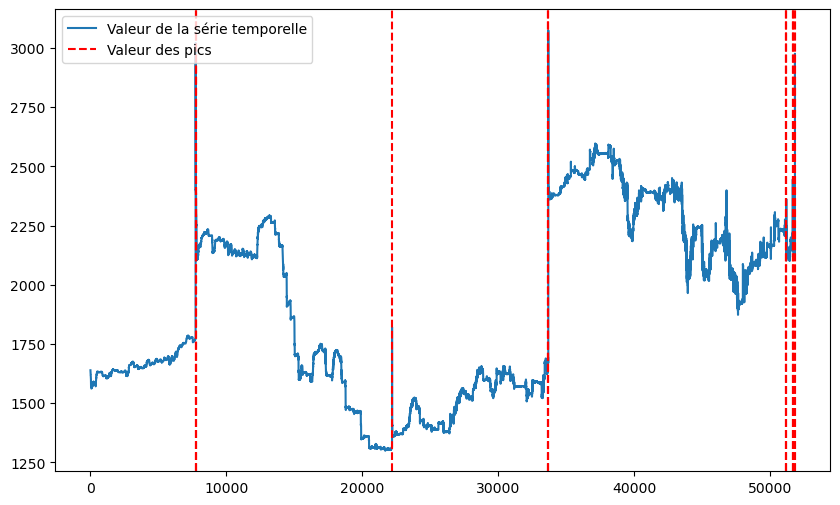

In [17]:
# Affichage des pics sur notre série temporelle pour vérifier si c'est cohérent 

plt.figure(figsize=(10, 6))
plt.plot(time_serie_crop, label='Valeur de la série temporelle')

# Ajout des barres verticales correspondant aux pics
for i,x in enumerate(pic):
    if i == 0:
        plt.axvline(x=x, color='red', linestyle='--', label='Valeur des pics')
    else:
        plt.axvline(x=x, color='red', linestyle='--')

plt.legend(loc='upper left')
plt.show()

In [19]:
data_clean = data_crop

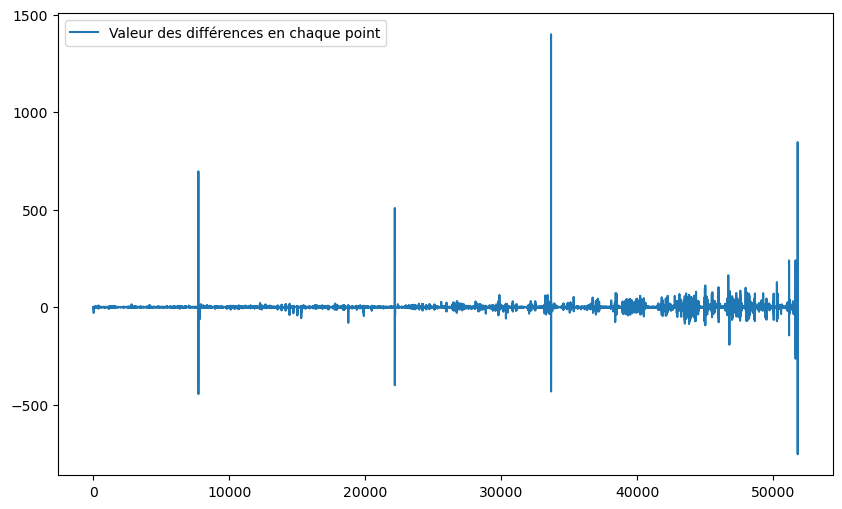

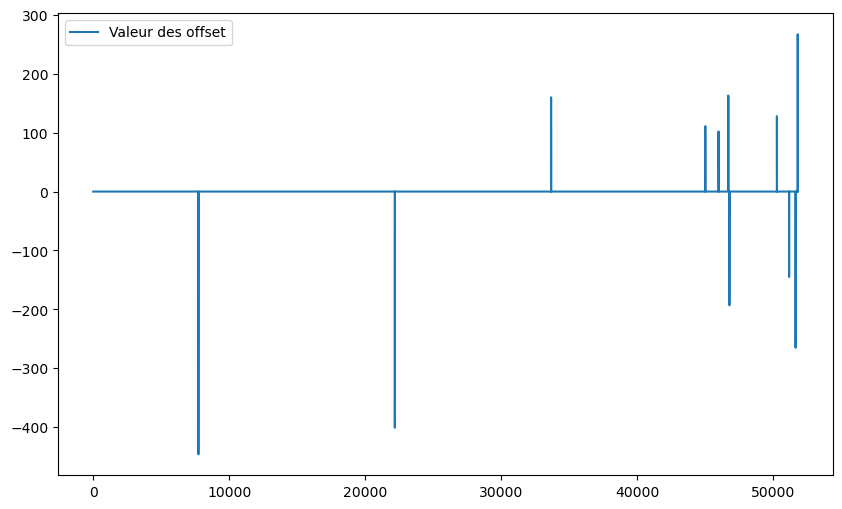

In [21]:
# Valeur des offset
data_diff = []
data_offset = []
k = 0
for i in range(0,len(data_clean)-1):
    data_diff.append(data_clean[i+1]-data_clean[i])
    if i == offset[k] : 
        data_offset.append(data_clean[i]-data_clean[i-1])
        if k < len(offset) -1 :
            k += 1
    else : 
        data_offset.append(0)
    
   
# Transformation en série temporelle
time_serie_diff = pd.Series(data_diff, dtype='float64')
time_serie_offset = pd.Series(data_offset, dtype='float64')

# Affichage de la série diff
plt.figure(figsize=(10, 6))
plt.plot(time_serie_diff, label='Valeur des différences en chaque point')
plt.legend()
plt.show()

# Affichage de la série offset
plt.figure(figsize=(10, 6))
plt.plot(time_serie_offset, label='Valeur des offset')
plt.legend()
plt.show()

## Suppression de l'offset

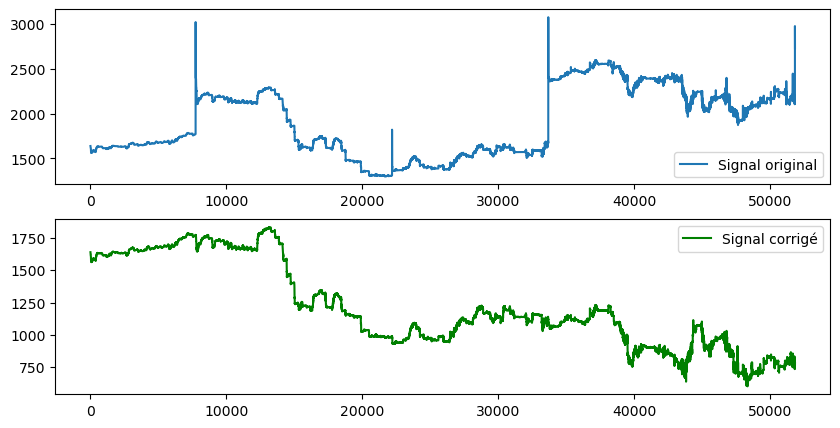

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Seuil de détection de saut (valeur à ajuster selon ton signal)
seuil_offset = 50

# Détection des sauts
sauts = np.where(np.abs(np.diff(data_clean)) > seuil_offset)[0]

# Correction du signal
data_ajust = data_clean.copy()
for saut in sauts:
    # Ajuster les valeurs après le saut en supprimant l'offset
    offset = data_ajust[saut+1] - data_ajust[saut]
    data_ajust[saut+1:] -= offset

# Visualisation avant et après correction
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(data_clean, label="Signal original")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(data_ajust, label="Signal corrigé", color='green')
plt.legend()
plt.show()


# Décomposition spéctrale

## Transformée de Fourier

rfft calcule la FFT pour un signal réel, ce qui est plus efficace et donne un résultat simplifié. La FFT transforme le signal data_ajust (une série temporelle) en une série de composantes fréquentielles, exprimées sous forme de nombres complexes.
np.real : Prend la partie réelle de la FFT, ce qui correspond aux amplitudes des composantes fréquentielles, en éliminant la partie imaginaire.

Dans le graphe, on prend la première moitié des fréquences et des amplitudes, car la seconde moitié (au-delà de la fréquence de Nyquist) est symétrique et n'apporte pas d'information nouvelle pour un signal réel.

Text(0, 0.5, 'Spectre Amplitude')

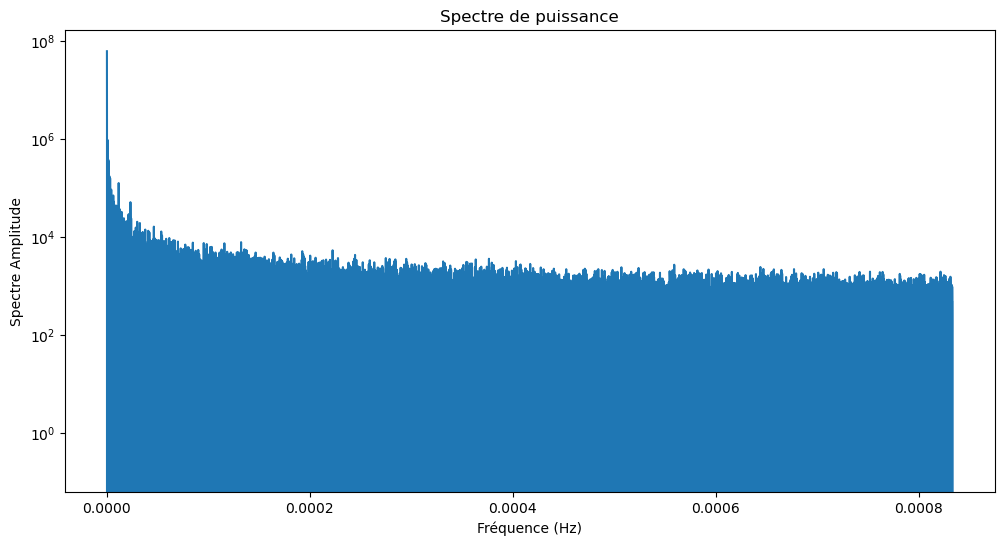

In [25]:
amplitudes = np.real(np.fft.rfft(data_ajust))

frequencies = np.fft.rfftfreq(len(data_ajust),5*60) # 900 = 5*60 : un point tout les 5 min


plt.figure(figsize=(12, 6))

plt.semilogy(frequencies[:len(frequencies)//2], amplitudes[:len(amplitudes)//2])
plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Spectre Amplitude')

Text(0, 0.5, 'Amplitude')

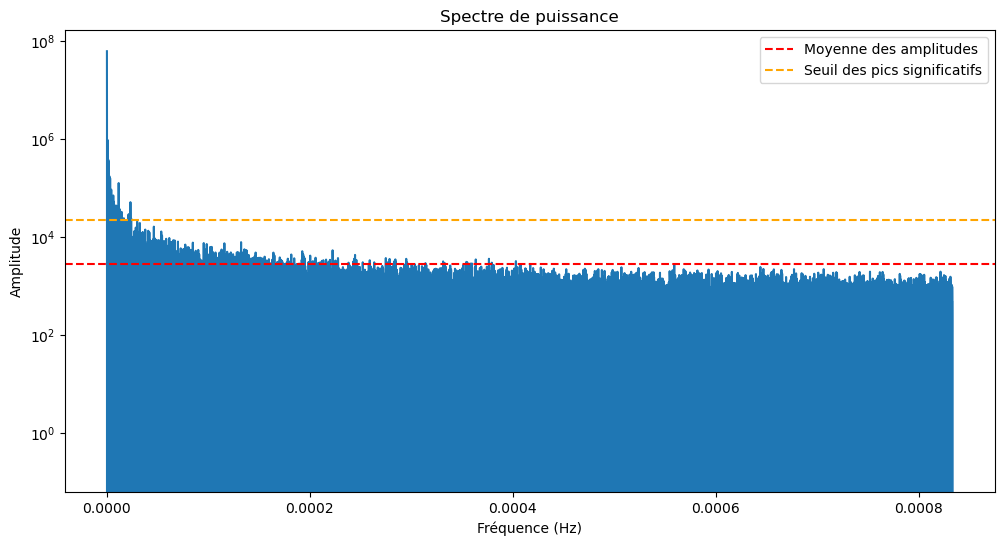

In [27]:
# Paramètres
T = 5*60  # Un point toutes les 5 min d'où 5*60
fs = 1 / T  
N = len(data_ajust) # Nombre de points

# Transformée de Fourier du signal
signal_fft = np.fft.rfft(data_ajust) # rfft car signal à valeurs réelles
frequences = np.fft.rfftfreq(N, T) # retourne sous forme de complexes
amplitudes = np.real(signal_fft) # on prend la partie réelle

plt.figure(figsize=(12, 6))

# on affiche que la moitié car pour un signal réel 
# au-delà de la fréquence de Nyquist cela n'apport pas plus d'informations
plt.semilogy(frequencies[:len(frequencies)//2], amplitudes[:len(amplitudes)//2])

# utile pour la suite
plt.axhline(y=np.mean(amplitudes), color='red', linestyle='--',label='Moyenne des amplitudes')
plt.axhline(y=np.mean(amplitudes)*8, color='orange', linestyle='--',label='Seuil des pics significatifs')
plt.legend()

plt.title('Spectre de puissance')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Amplitude')

In [29]:
# Détection des pics dans le spectre d'amplitude
peaks, _ = scipy.signal.find_peaks(amplitudes, height=np.mean(amplitudes) * 8)  # Seulement les pics significatifs

# Première fréquence dominante
frequence_principale = frequences[peaks[0]] 
periode_principale = 1 / frequence_principale 
print(f"Fréquence dominante : {frequence_principale*1e8:.5f} 1e-8 Hz, soit une période d'environ {periode_principale / (3600*24):.2f} jours")

Fréquence dominante : 25.73605 1e-8 Hz, soit une période d'environ 44.97 jours


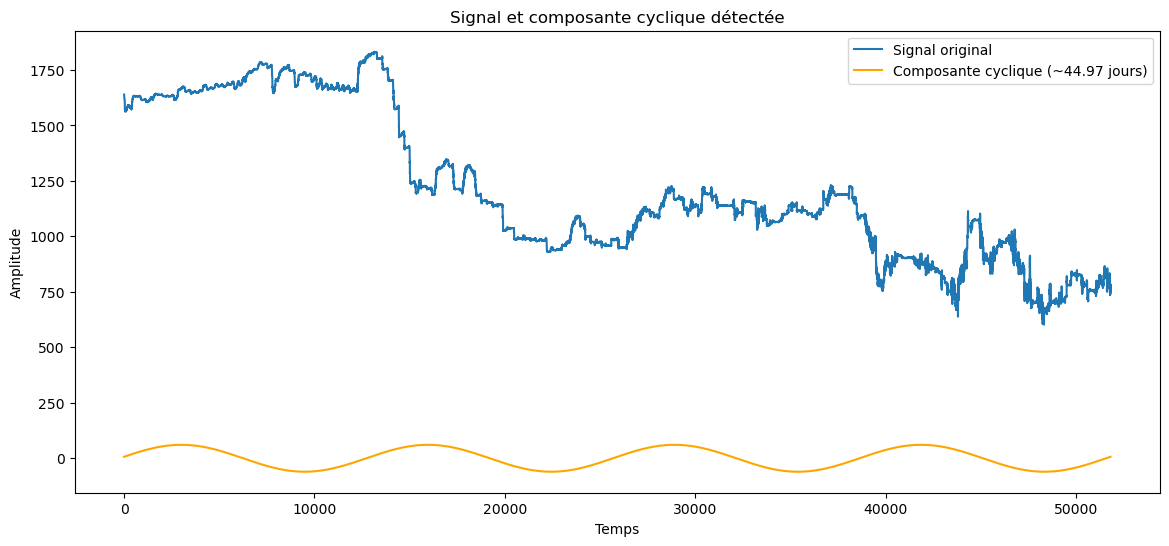

In [31]:
# Filtrage autour de la fréquence dominante
largeur_bande = frequence_principale / 10  # Largeur de bande autour de la fréquence dominante (j'ai testé différentes valeurs)
filtre_cyclique = (np.abs(np.fft.rfftfreq(N, T) - frequence_principale) < largeur_bande)

# Appliquer le filtre pour isoler la composante cyclique
signal_cyclique_fft = signal_fft * filtre_cyclique
signal_cyclique = np.fft.irfft(signal_cyclique_fft)


# Affichage du signal original et de sa composante cyclique
plt.figure(figsize=(14, 6))
plt.plot(data_ajust, label="Signal original")
plt.plot(signal_cyclique.real, label=f"Composante cyclique (~{periode_principale / (3600*24):.2f} jours)", color="orange")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal et composante cyclique détectée")
plt.legend()
plt.show()

### Reconstruire le signal avec les fréquences principales

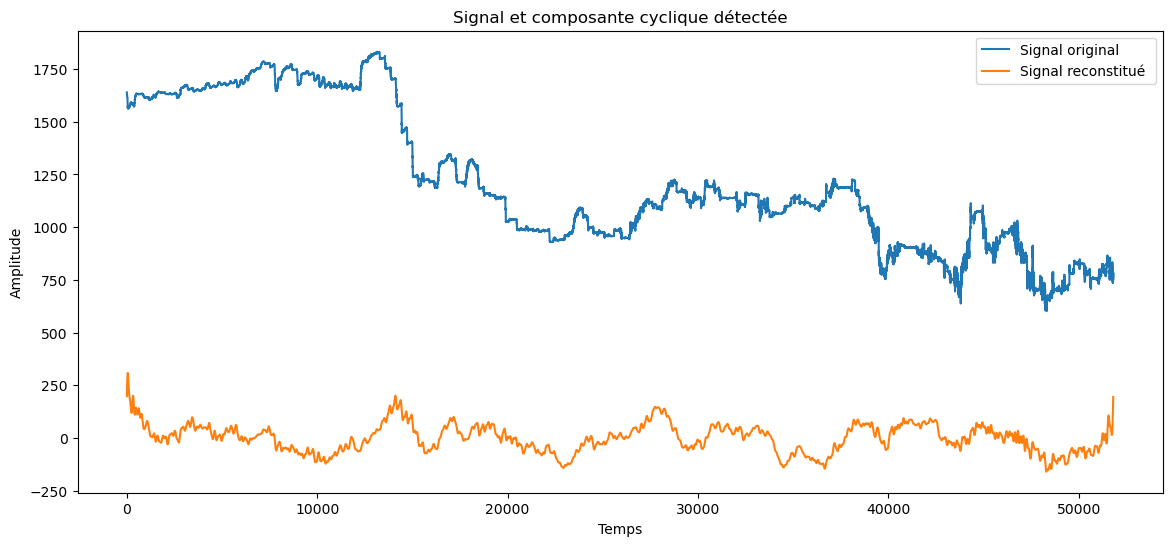

In [33]:
signal_rec = np.zeros(len(data_ajust))
peaks, _ = scipy.signal.find_peaks(amplitudes, height=np.mean(amplitudes) * 8) 
for p in peaks :
    largeur_bande = frequences[p] / 100  # Largeur de bande autour de la fréquence dominante (j'ai testé différentes valeurs)
    filtre_cyclique = (np.abs(np.fft.rfftfreq(N, T) - frequences[p]) < largeur_bande)

    # Appliquer le filtre pour isoler la composante cyclique
    signal_cyclique_fft = signal_fft * filtre_cyclique
    signal_cyclique = np.fft.irfft(signal_cyclique_fft)
    signal_rec += signal_cyclique

plt.figure(figsize=(14, 6))
plt.plot(data_ajust, label="Signal original")
plt.plot(signal_rec, label="Signal reconstitué ")
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.title("Signal et composante cyclique détectée")
plt.legend()
plt.show()

## Densité spectrale Welch

In [47]:
# pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 564.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 18.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [35]:
from scipy.signal import welch

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Implémentation de la méthode de Welch
def welch_manual(data, fs, nperseg, noverlap=None):
    # Taille du signal
    n = len(data)
    
    # Calcul de l'overlap
    if noverlap is None:
        noverlap = nperseg // 2
    
    # Nombre de segments
    nsegments = (n - nperseg) // (nperseg - noverlap) + 1
    
    # Fréquences de la FFT
    freqs = np.fft.fftfreq(nperseg, d=1/fs)
    freqs = freqs[:nperseg//2]  # On ne garde que les fréquences positives
    
    # Densité spectrale de puissance
    psd = np.zeros(len(freqs))
    
    for i in range(nsegments):
        # Indices de début et de fin de chaque segment
        start = i * (nperseg - noverlap)
        end = start + nperseg
        
        # Segment du signal
        segment = data[start:end]
        
        # FFT du segment
        fft_segment = np.fft.fft(segment)
        
        # Calcul de la puissance (module au carré de la FFT)
        psd_segment = np.abs(fft_segment[:nperseg//2])**2
        
        # Moyenne des PSDs sur les segments
        psd += psd_segment
    
    psd /= nsegments  # Moyenne sur les segments
    
    return freqs, psd

(33004977.547554456-1.3427762977818136e-11j)


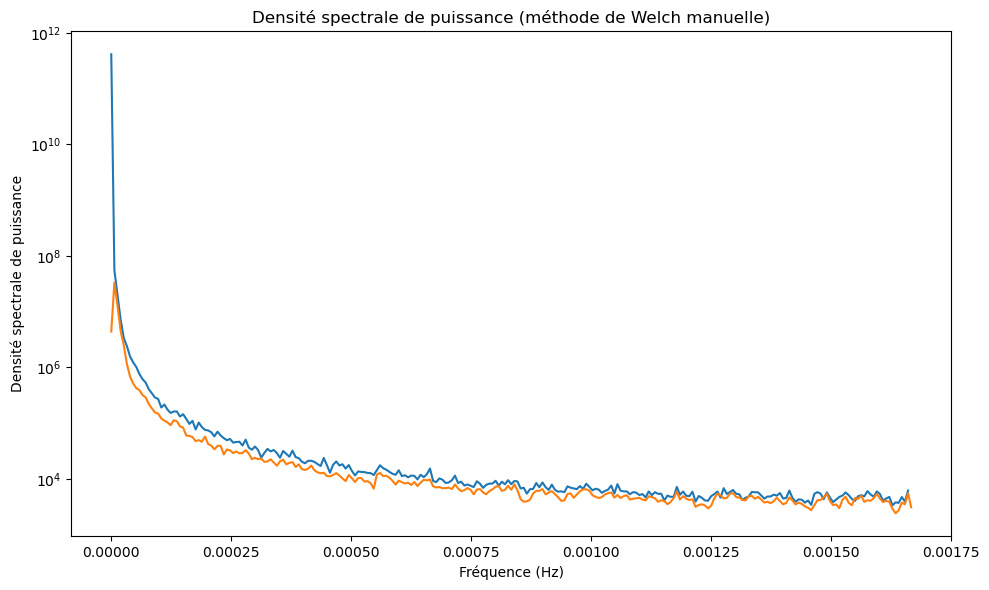

1
6.510416666666667e-06
Fréquence avec la plus grande PSD en manuel : 1.7777777777777777 j
Fréquence avec la plus grande PSD en auto : 1.7777777777777777 j


In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

# Paramètres de la méthode de Welch
nperseg = 512
noverlap = int(nperseg /2 )
fs = 1 / (60*5)

# Estimation de la PSD avec notre implémentation manuelle de Welch
frequencies_manual, psd_manual = welch_manual(data_ajust, fs, nperseg, noverlap)
frequencies_auto, psd_auto = welch(data_ajust, fs=fs, nperseg=nperseg , noverlap=noverlap, window="hann", scaling = "density")

# Tracé du résultat
plt.figure(figsize=(10, 6))
plt.semilogy(frequencies_manual, psd_manual)
plt.semilogy(frequencies_auto, np.abs(psd_auto))
plt.title('Densité spectrale de puissance (méthode de Welch manuelle)')
plt.xlabel('Fréquence (Hz)')
plt.ylabel('Densité spectrale de puissance')
plt.tight_layout()
plt.show()

max_psd_index_a = np.argmax(np.abs(psd_auto))
print(max_psd_index_a)
max_psd_frequency_a = frequencies_manual[max_psd_index_a]
print(max_psd_frequency_a)

max_psd_index_m = np.argmax(np.abs(psd_manual[1:]))
max_psd_frequency_m = frequencies_auto[max_psd_index_m+1]


# Afficher la fréquence avec la plus grande PSD
print(f"Fréquence avec la plus grande PSD en manuel : {(1/max_psd_frequency_m)/(60*60*24)} j")
print(f"Fréquence avec la plus grande PSD en auto : {(1/max_psd_frequency_a)/(60*60*24)} j")

1
6.510416666666667e-06
La plus basse fréquence principale est : 6.510416666666667e-06 Hz
Ca correspond à  : 1.7777777777777777 jours


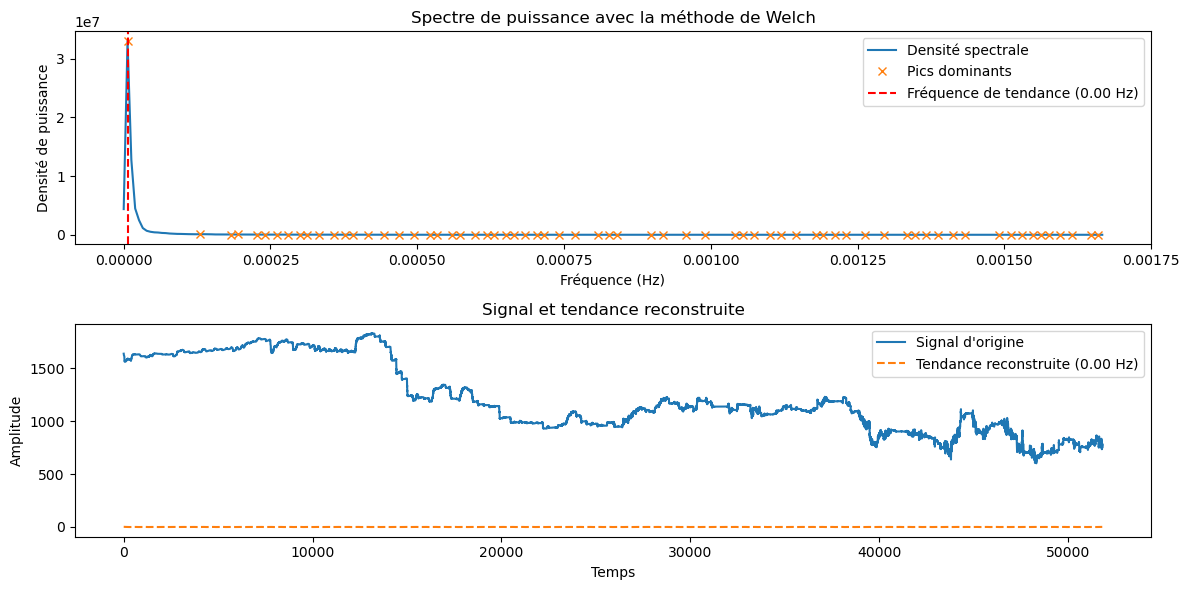

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks
from scipy.fft import ifft

signal = data_ajust  
T = 60*5 
fs = 1 / T  

# Décomposition spectrale de Welch
frequencies, power_spectral_density = welch(signal, fs=fs, nperseg=512, noverlap = 512/2)

# Identification des fréquences dominantes
peaks, _ = find_peaks(np.abs(power_spectral_density))
dominant_frequencies = frequencies[peaks]
dominant_powers = power_spectral_density[peaks]

# Recherche de la plus basse fréquence dominante
max_psd_index = np.argmax(np.abs(power_spectral_density))
print(max_psd_index)
max_psd_frequency = frequencies[max_psd_index]
print(max_psd_frequency)

print(f"La plus basse fréquence principale est : {max_psd_frequency} Hz")
print(f"Ca correspond à  : {(1/max_psd_frequency) /(60*60*24)} jours")

# Reconstruction de la tendance par filtrage
# On construit un signal harmonique avec la fréquence de tendance
t = np.arange(len(signal)) / fs
trend = np.cos(2 * np.pi * max_psd_frequency * t)

# Visualisation
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(frequencies, np.abs(power_spectral_density), label="Densité spectrale")
plt.plot(dominant_frequencies, np.abs(dominant_powers), "x", label="Pics dominants")
plt.axvline(max_psd_frequency, color='r', linestyle='--', label=f"Fréquence de tendance ({max_psd_frequency:.2f} Hz)")
plt.xlabel("Fréquence (Hz)")
plt.ylabel("Densité de puissance")
plt.legend()
plt.title("Spectre de puissance avec la méthode de Welch")

plt.subplot(2, 1, 2)
plt.plot(signal, label="Signal d'origine")
plt.plot(trend, label=f"Tendance reconstruite ({max_psd_frequency:.2f} Hz)", linestyle='--')
plt.xlabel("Temps")
plt.ylabel("Amplitude")
plt.legend()
plt.title("Signal et tendance reconstruite")

plt.tight_layout()
plt.show()


# Série temporelle

### Modélisation avec la librairie STL

On a remarqué que les points étaient relevés toutes les 15 mins (pour les 2 premiers mois) après c'est toutes les 5 mins

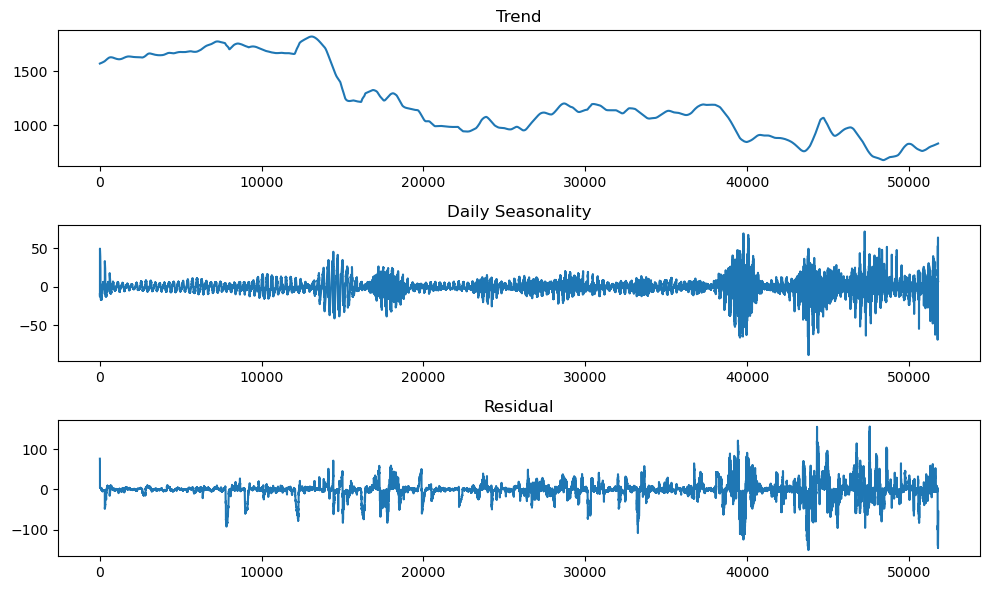

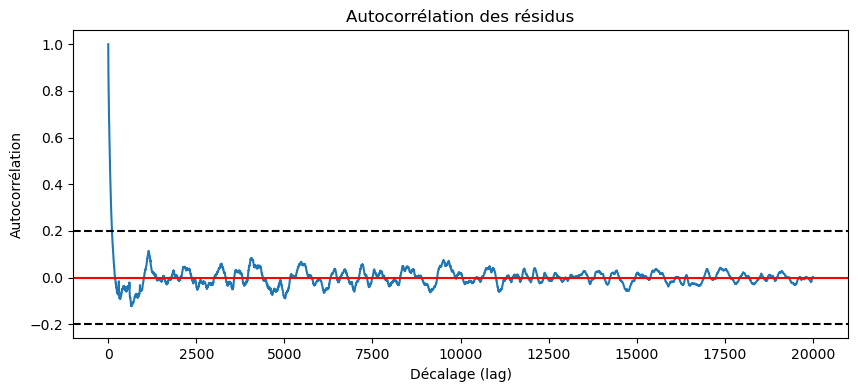

In [184]:
from statsmodels.tsa.seasonal import STL
import statsmodels.api as sm

data = pd.Series(data_ajust)

stl = STL(data, period=5*60, robust = True)
result = stl.fit()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))
ax1.plot(result.trend)
ax1.set_title('Trend')
ax2.plot(result.seasonal)
ax2.set_title('Daily Seasonality')
ax3.plot(result.resid)
ax3.set_title('Residual')
plt.tight_layout()
plt.show()

max_lag = 20000
acf_values = sm.tsa.acf(result.resid, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 4))
plt.plot(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

### Modélisation avec la librairie MSTL

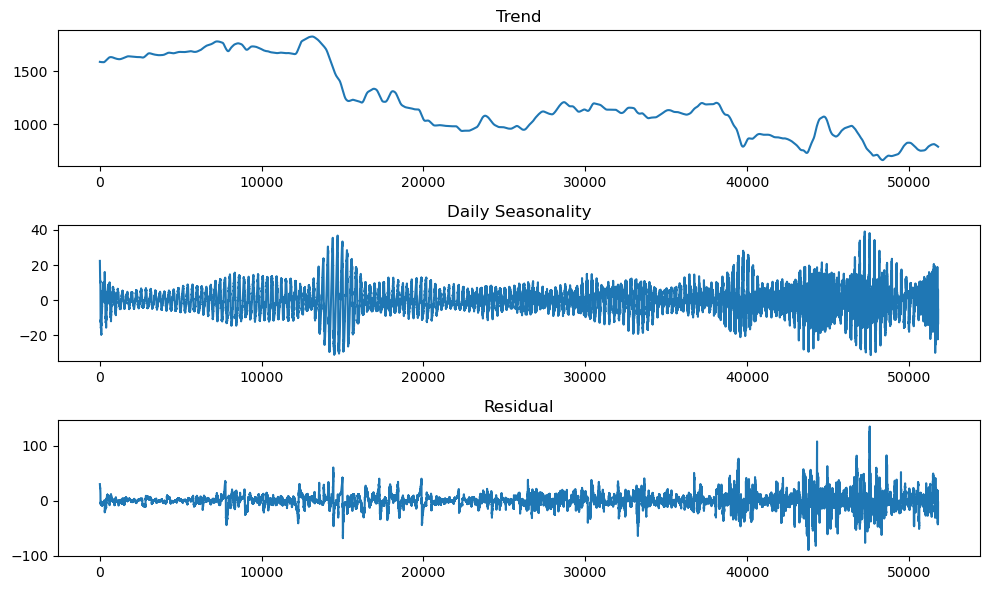

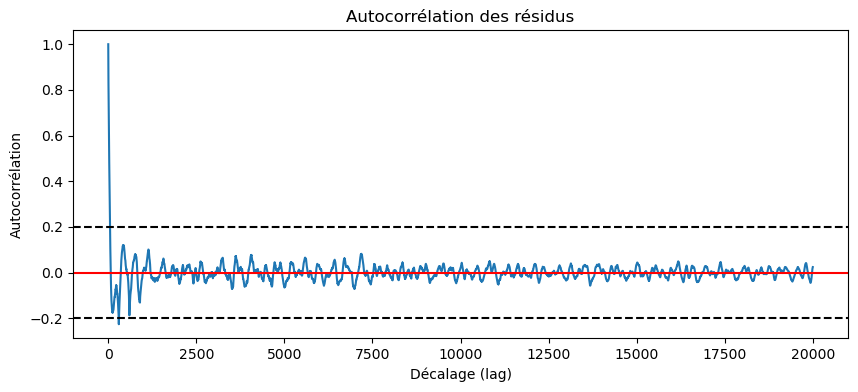

In [182]:
from statsmodels.tsa.seasonal import MSTL

data = pd.Series(data_ajust)

mstl = MSTL(data, periods=5*60)
result = mstl.fit()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))
ax1.plot(result.trend)
ax1.set_title('Trend')
ax2.plot(result.seasonal)
ax2.set_title('Daily Seasonality')
ax3.plot(result.resid)
ax3.set_title('Residual')
plt.tight_layout()
plt.show()

max_lag = 20000
acf_values = sm.tsa.acf(result.resid, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 4))
plt.plot(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

### Moyennes mobiles

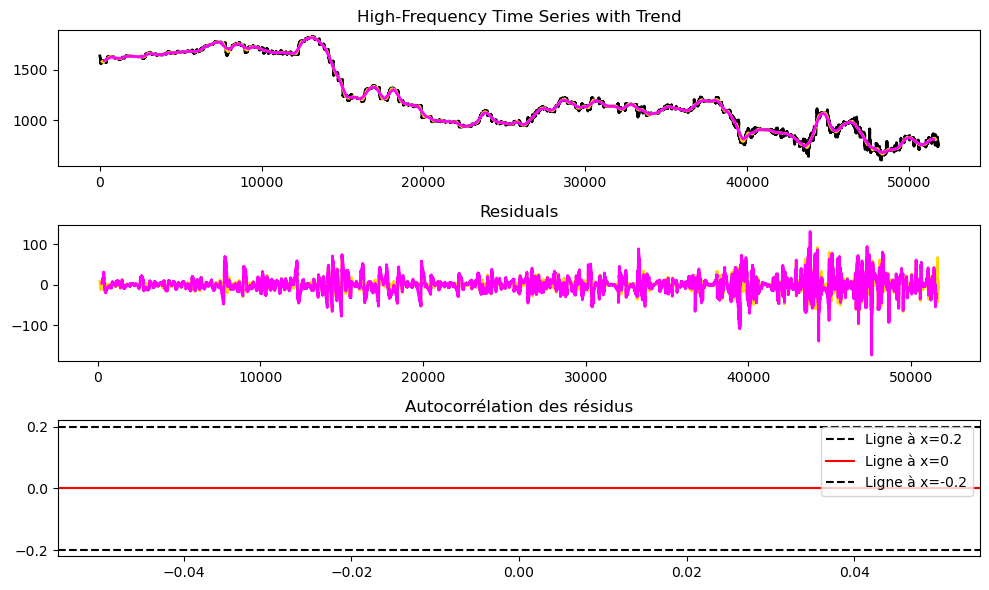

In [99]:
# Calculate rolling mean (adjust window to 96 for daily trends)
rolling_mean_d = data.rolling(window=24*12, center=True).mean()
rolling_mean_p = data.rolling(window=int(12*periode_principale/(3600*24)), center=True).mean()

# Calcul des résidus
daily = rolling_mean_d-data
princ = rolling_mean_p-data

# Calcul de l'autocorrélation
max_lag = 20000
acf_values_daily = sm.tsa.acf(daily, nlags = max_lag)
acf_values_princ = sm.tsa.acf(princ, nlags = max_lag)


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6))

# Affichage des data
ax1.plot(data, label='Original Data', color='black', linewidth=2)
ax1.plot(rolling_mean_d, label='Trend journalière', color='gold', linewidth=2)
ax1.plot(rolling_mean_p, label='Trend de la fréquence principale', color='fuchsia', linewidth=2)
ax1.set_title('High-Frequency Time Series with Trend')

# Affichage des résidus
ax2.plot(daily, label='daily', color='gold', linewidth=2)
ax2.plot(princ, label='princ', color='fuchsia', linewidth=2)
ax2.set_title('Residuals')

# Affichage de l'autocorrélation
ax3.plot(range(max_lag + 1), acf_values_daily, color='gold')
ax3.plot(range(max_lag + 1), acf_values_princ, color='fuchsia')
ax3.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
ax3.axhline(y=0, color='red', label='Ligne à x=0')
ax3.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
ax3.set_title("Autocorrélation des résidus")
plt.legend()
plt.tight_layout()
plt.show()

### Modélisation à la main

#### Filtre passe-bas (Butterworth)

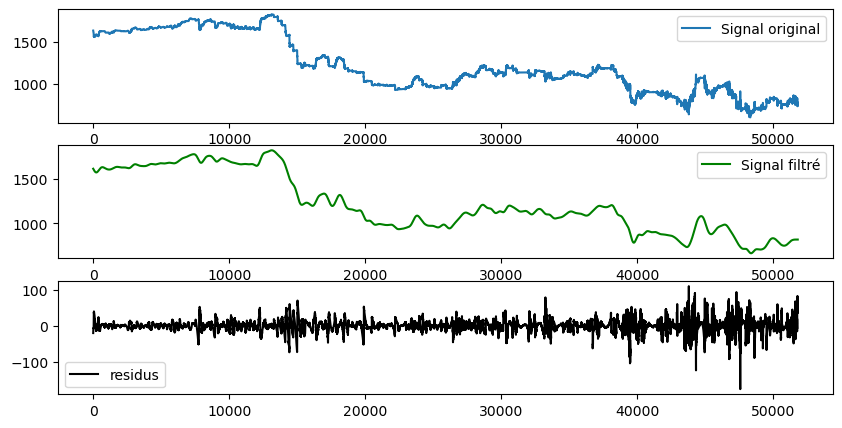

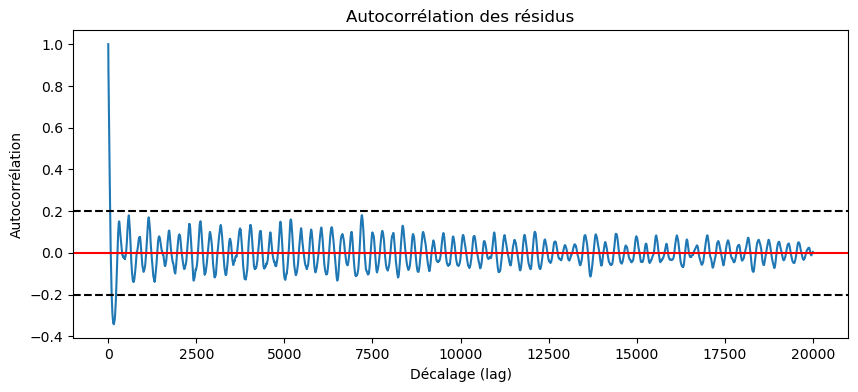

In [140]:
# Plot de la tendance à l'aide d'un filtre passe-bas
from scipy.signal import butter, filtfilt
import statsmodels.api as sm

# Paramètres du filtre
ordre = 5
frequence_coupure = 1/(60*5)

# Création du filtre passe-bas
b, a = butter(ordre, frequence_coupure, btype='low', analog=False)

# Application du filtre
data_filtre = filtfilt(b, a, data_ajust)

residus = data_filtre - data_ajust

# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(data_ajust, label="Signal original")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(data_filtre, label="Signal filtré", color='green')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(residus, label="residus", color='black')
plt.legend()
plt.show()

# Choix du nombre de décalages (lags) à afficher
max_lag = 20000
acf_values = sm.tsa.acf(residus, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 4))
plt.plot(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

#### Filtre passe-bas (Savitzky-Golay)

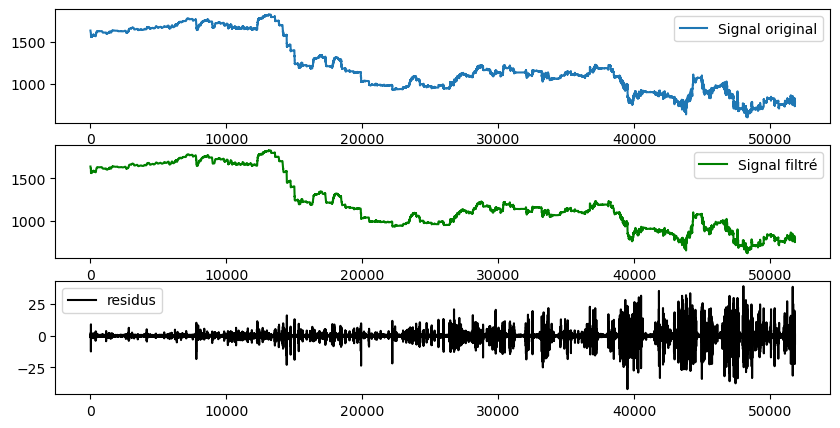

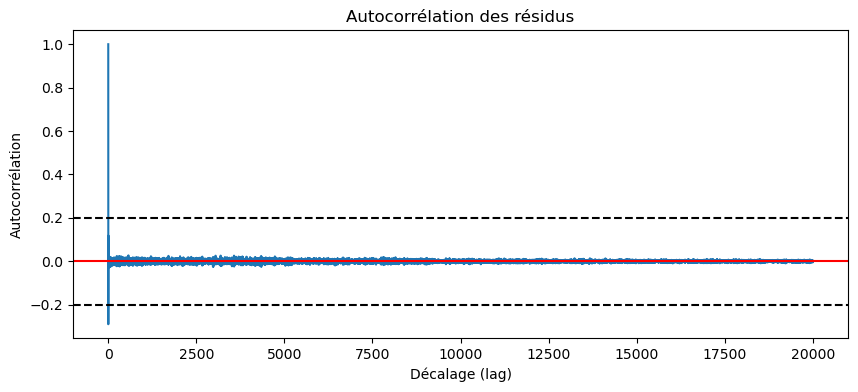

In [163]:
# Plot de la tendance à l'aide d'un filtre passe-bas
from scipy.signal import savgol_filter, filtfilt
import statsmodels.api as sm

# Paramètres du filtre
ordre = 5
frequence_coupure = 1/(60*5)

# Création du filtre passe-bas
data_filtre = savgol_filter(data_ajust,10,2)

residus = data_filtre - data_ajust

# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(data_ajust, label="Signal original")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(data_filtre, label="Signal filtré", color='green')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(residus, label="residus", color='black')
plt.legend()
plt.show()

# Choix du nombre de décalages (lags) à afficher
max_lag = 20000
acf_values = sm.tsa.acf(residus, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 4))
plt.plot(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()

#### Lissage exponentiel

In [150]:
import numpy as np

def lissage_exponentiel(data, alpha):
    """
    Applique un lissage exponentiel à une série de données.

    :param data: Liste ou array des données brutes.
    :param alpha: Coefficient de lissage (0 < alpha ≤ 1).
    :return: Array des valeurs lissées.
    """
    if not (0 < alpha <= 1):
        raise ValueError("Le coefficient alpha doit être compris entre 0 et 1.")
    
    # Initialisation de la liste des valeurs lissées
    lissage = np.zeros_like(data, dtype=float)
    lissage[0] = data[0]  # La première valeur lissée est identique à la première donnée brute

    # Application du lissage exponentiel
    for t in range(1, len(data)):
        lissage[t] = alpha * data[t] + (1 - alpha) * lissage[t-1]
    
    return lissage


<Figure size 1200x600 with 0 Axes>

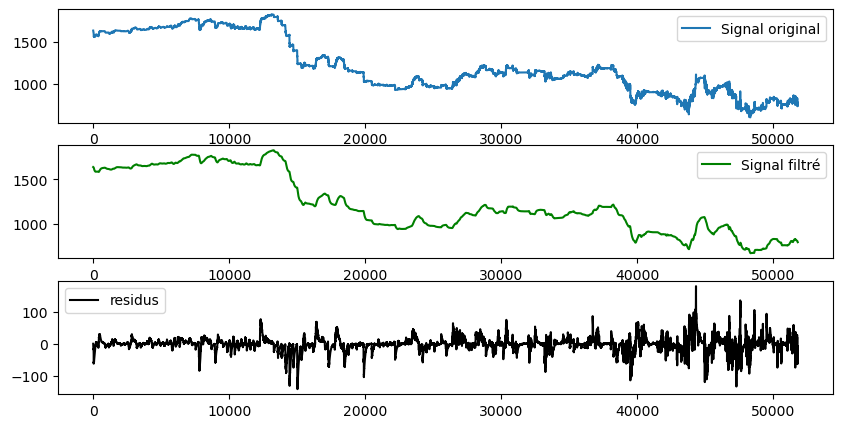

<Figure size 640x480 with 0 Axes>

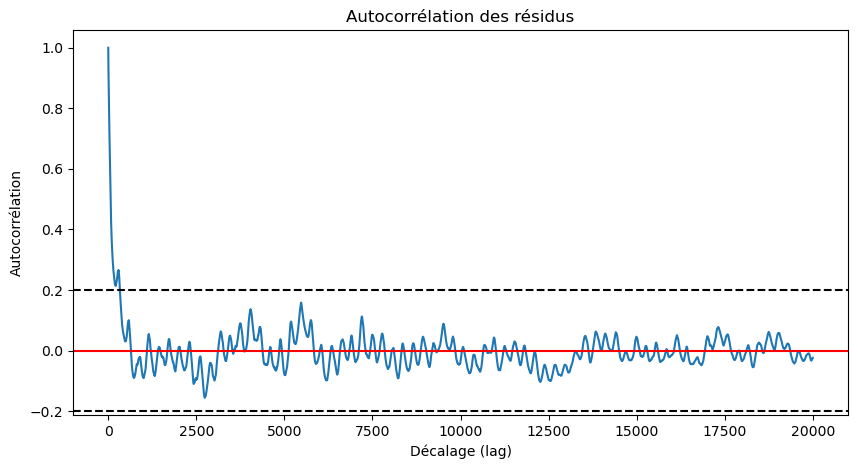

In [152]:
# Calcul des données lissées et des résidus
alpha=0.01
lissage_resultat = lissage_exponentiel(data_ajust, alpha)
residus = data_ajust - lissage_resultat

# Tracé des résultats
plt.figure(figsize=(12, 6))

# Graphique des données brutes et lissées
# Visualisation avant et après filtrage
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(data_ajust, label="Signal original")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(lissage_resultat, label="Signal filtré", color='green')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(residus, label="residus", color='black')
plt.legend()
plt.show()

plt.tight_layout()
plt.show()

# Choix du nombre de décalages (lags) à afficher
max_lag = 20000
acf_values = sm.tsa.acf(residus, nlags = max_lag)

# Affichage de l'autocorrélation
plt.figure(figsize=(10, 5))
plt.plot(range(max_lag + 1), acf_values)
plt.axhline(y=0.2, color='black', linestyle='--', label='Ligne à x=0.2')
plt.axhline(y=0, color='red', label='Ligne à x=0')
plt.axhline(y=-0.2, color='black', linestyle='--', label='Ligne à x=-0.2')
plt.xlabel("Décalage (lag)")
plt.ylabel("Autocorrélation")
plt.title("Autocorrélation des résidus")
plt.show()